In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import rawpy
import sys
import os
import gc
import time
import random
from glob import glob
from tqdm import tqdm
from collections import defaultdict
from IPython import display
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity as SSIM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam

D:\Tool\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.models as models

class InvISP(nn.Module):
    def __init__(
        self,
        in_size=3,
        out_size=4,
        target_size=(512, 512),
        hidden_size=128,
        n_layers=8,
        gammas=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
    ):

        super().__init__()

        self.gammas = gammas

        self.hidden_size = hidden_size
        self.target_size = target_size

        self.color_reconstruction = ColorReconstructionModule(
            in_size=in_size,
            hidden_size=hidden_size,
            out_size=hidden_size,
            n_layers=n_layers,
        )

        self.global_context_encoder = GlobalContextModule(hidden_size)
        self.gamma_scaling_encoder = GlobalContextModule(len(self.gammas))
        self.softmax = nn.Softmax(dim=1)

        self.heads = nn.ModuleList()
        for _ in range(len(self.gammas)):
            self.heads.append(
                Head(
                    in_size=hidden_size,
                    hidden_size=hidden_size,
                    out_size=out_size,
                    n_layers=n_layers,
                )
            )

    def forward(self, x, global_img):
        b, c, h, w = global_img.size()

        global_features = self.global_context_encoder(global_img)
        global_features = global_features.view(b, self.hidden_size, 1, 1)
        global_features = global_features.repeat(1, 1, self.target_size[0], self.target_size[1])

        x = self.color_reconstruction(x)
        x = x * global_features

        scaling = self.gamma_scaling_encoder(global_img)
        scaling = self.softmax(scaling)

        y = 0
        outputs = []

        for head_no, head in enumerate(self.heads):
            scale = scaling[:, head_no : head_no + 1].view(b, 1, 1, 1).repeat(1, 4, 1, 1)
            y0 = torch.clip(head(x), 0, None)
            y += torch.pow(y0, 1 / self.gammas[head_no]) * scale
            outputs.append(y0)
        
        outputs = torch.cat(outputs, dim=1)
        outputs = outputs[:, :4, :, :]

        return y, outputs, scaling


class ColorReconstructionModule(nn.Module):
    def __init__(
        self,
        in_size=3,
        initial_size=32,
        hidden_size=128,
        out_size=128,
        n_layers=4,
        bias=True,
        act=nn.LeakyReLU,
        val=0.1,
    ):

        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(
                    in_size,
                    initial_size * in_size,
                    kernel_size=3,
                    stride=1,
                    padding=0,
                    bias=bias,
                    padding_mode="reflect",
                    groups=3,
                ),
                act(val),
            )
        )
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(initial_size * in_size, hidden_size, kernel_size=2, stride=2, bias=bias),
                act(val),
            )
        )
        for i in range(n_layers-1):
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(hidden_size, hidden_size, kernel_size=1, stride=1, bias=bias),
                    act(val),
                )
            )
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(hidden_size, out_size, kernel_size=1, stride=1, bias=bias), act(val)
            )
        )

        for seq in self.layers:
            for layer in seq.children():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layers[0](x)
        x = self.layers[1](x)
        for layer in self.layers[2:-1]:
            x = x + layer(x)
        x = self.layers[-1](x)

        x = F.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)  # 调整大小
        return x


class GlobalContextModule(nn.Module):
    def __init__(self, out_size=128):
        super().__init__()
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(512, out_size)
        # self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = self.act(x)
        return x


class Head(nn.Module):
    def __init__(
        self,
        in_size=128,
        hidden_size=128,
        out_size=4,
        n_layers=4,
        bias=True,
        act=nn.LeakyReLU,
        val=0.1,
    ):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(
            nn.Sequential(
                nn.Conv2d(in_size, hidden_size, kernel_size=1, stride=1, padding=0, bias=bias),
                act(val),
            )
        )
        for i in range(n_layers - 2):
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        hidden_size, hidden_size, kernel_size=1, stride=1, padding=0, bias=bias
                    ),
                    act(val),
                )
            )

        self.layers.append(
            nn.Sequential(
                nn.Conv2d(hidden_size, out_size, kernel_size=1, stride=1, padding=0, bias=bias),
                act(val),
            )
        )

        for seq in self.layers:
            for layer in seq.children():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layers[0](x)
        for layer in self.layers[1:-1]:
            x = x + layer(x)
        x = self.layers[-1](x)
        return x


class l1_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss = torch.abs(x - y).mean()
        return loss


class hard_log_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss = (-1 * torch.log(1 - torch.clamp(torch.abs(x - y),0,1) + 1e-6)).mean()
        return loss

class CFG:
    
    encoder = (3,64,128,256)
    decoder = (256, 128, 64)
    out_ch  = 4
    out_sz  = (512, 512)
    lr      = 8e-5
    lr_decay= 1e-6
    epochs  = 100
    loss    = nn.MSELoss()
    name    = 'unet-rev-isp.pt'
    out_dir = './out5'
    save_freq = 1

In [3]:
PATH    = f'data'
def get_filenames(path):
    train_raws = sorted(glob(PATH + '/train/*.npy'))
    train_rgbs = sorted(glob(PATH + '/train/*.png'))
    #==========================================!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!+=============================================
    valid_rgbs = sorted(glob(PATH + '/train/*.png'))
    assert len(train_raws) == len(train_rgbs)
    print (f'Training samples: {len(train_raws)} \t Validation samples: {len(valid_rgbs)}')
    return train_raws, train_rgbs, valid_rgbs

def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:   
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())
        
    if resize:
        img = cv2.resize(img, (resize[0], resize[1]), interpolation = cv2.INTER_AREA)
        
    return img

def save_rgb (img, filename):
    if np.max(img) <= 1:
        img = img * 255
    
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    cv2.imwrite(filename, img)
    

def load_raw(raw, max_val=2**10):
    raw = np.load (raw)/ max_val
    return raw.astype(np.float32)


########## VISUALIZATION

def demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
    """
    
    assert raw.shape[-1] == 4
    shape = raw.shape
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = np.stack((red, avg_green, blue), axis=-1)
    image      = cv2.resize(image, (shape[1]*2, shape[0]*2))
    return image


def mosaic(rgb):
    """Extracts RGGB Bayer planes from an RGB image."""
    
    assert rgb.shape[-1] == 3
    shape = rgb.shape
    
    red        = rgb[0::2, 0::2, 0]
    green_red  = rgb[0::2, 1::2, 1]
    green_blue = rgb[1::2, 0::2, 1]
    blue       = rgb[1::2, 1::2, 2]
    
    image = np.stack((red, green_red, green_blue, blue), axis=-1)
    return image


def gamma_compression(image):
    """Converts from linear to gamma space."""
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    """Simple S-curved global tonemap"""
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    """Simple post-processing to visualize demosaic RAW imgaes
    Input:  (h,w,3) RAW image normalized
    Output: (h,w,3) post-processed RAW image
    """
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

def plot_pair (rgb, raw, t1='RGB', t2='RAW', axis='off'):
    
    fig = plt.figure(figsize=(16, 8), dpi=100)
    plt.subplot(1,2,1)
    plt.title(t1)
    plt.axis(axis)
    plt.imshow(rgb)

    plt.subplot(1,2,2)
    plt.title(t2)
    plt.axis(axis)
    plt.imshow(raw)
    plt.show()

########## METRICS

def PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if(mse == 0):  
        return np.inf
    
    max_pixel = np.max(y_true)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr
class LoadData(Dataset):

    def __init__(self, root, rgb_files, raw_files=None, debug=False, test=None):
        
        self.root = root
        self.test = test
        self.rgbs = sorted(rgb_files)
        if self.test:
            self.raws = None
        else:
            self.raws = sorted(raw_files)
            
        self.debug = debug
        if self.debug:
            self.rgbs = self.rgbs[:100]
            self.raws = self.raws[:100]
        
    def __len__(self):
        return len(self.rgbs)

    def __getitem__(self, idx):

        rgb = load_img (self.rgbs[idx], norm=True)
        rgb = torch.from_numpy(rgb.transpose((2, 0, 1)))
        
        if self.test:
            return rgb, self.rgbs[idx]
        else:
            raw = load_raw (self.raws[idx])
            raw = torch.from_numpy(raw.transpose((2, 0, 1)))
            return rgb, raw
train_raws, train_rgbs, valid_rgbs = get_filenames(PATH)
BATCH_TEST  = 1
test_dataset = LoadData(root=PATH, rgb_files=valid_rgbs, test=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_TEST, shuffle=False, num_workers=0,
                         pin_memory=True, drop_last=False)

Training samples: 2121 	 Validation samples: 2121


In [ ]:
model = InvISP()
# 加载权重文件
device = torch.device("cuda")
pretrained_weights_path = r"F:\研究生\CVPR-workshop\rgb2raw\69.pt"
model = torch.load(pretrained_weights_path, map_location=device, weights_only=False)
model = model.to(device)

D:\Tool\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Tool\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
SUBMISSION_PATH = './submission/'
runtime = []

see_map1 = {}
see_map2 = {}

cnt = 0
model.eval()
with torch.no_grad():
    for (rgb_batch, rgb_name) in tqdm(test_loader):
        rgb_batch = rgb_batch.to(device)
        rgb_name  = rgb_name[0].split('/')[-1].replace('.png', '')
        
        st = time.time()
        y, outputs, _ = model(rgb_batch, rgb_batch)

        # ============ ============= ========== ============== ============= =================  结果有两个
        recon_raw = outputs
        
        tt = time.time() - st
        runtime.append(tt)
        
        recon_raw = recon_raw[0].detach().cpu().permute(1, 2, 0).numpy()
        rgb_batch = rgb_batch[0].detach().cpu().permute(1, 2, 0).numpy()


        see_map1[rgb_name] = (rgb_batch)
        see_map2[rgb_name] = postprocess_raw(demosaic(recon_raw))
        
        
        if cnt == 120:
            break
        
        ## save as np.uint16
        assert recon_raw.shape[-1] == 4
        recon_raw = (recon_raw * 1024).astype(np.uint16)
        np.save(SUBMISSION_PATH + rgb_name + '.npy', recon_raw) 
        cnt+=1

print (np.mean(runtime)) ## add into the readme!

  6%|████▍                                                                          | 120/2121 [00:42<11:49,  2.82it/s]

0.017137292988044173


In [6]:

def showimg(it):
    plot_pair(see_map1[it], see_map2[it])
    image_data = np.load('F:\\研究生\\CVPR-workshop\\rgb2raw\\data\\'+it.replace('\\', '\\\\')+'.npy')
    raw = postprocess_raw(demosaic(image_data.astype(np.float32) / 1024))
    fig = plt.figure(figsize=(6, 6), dpi=100)
    plt.title('origin')
    plt.axis('off')
    plt.imshow(raw)
    plt.show()


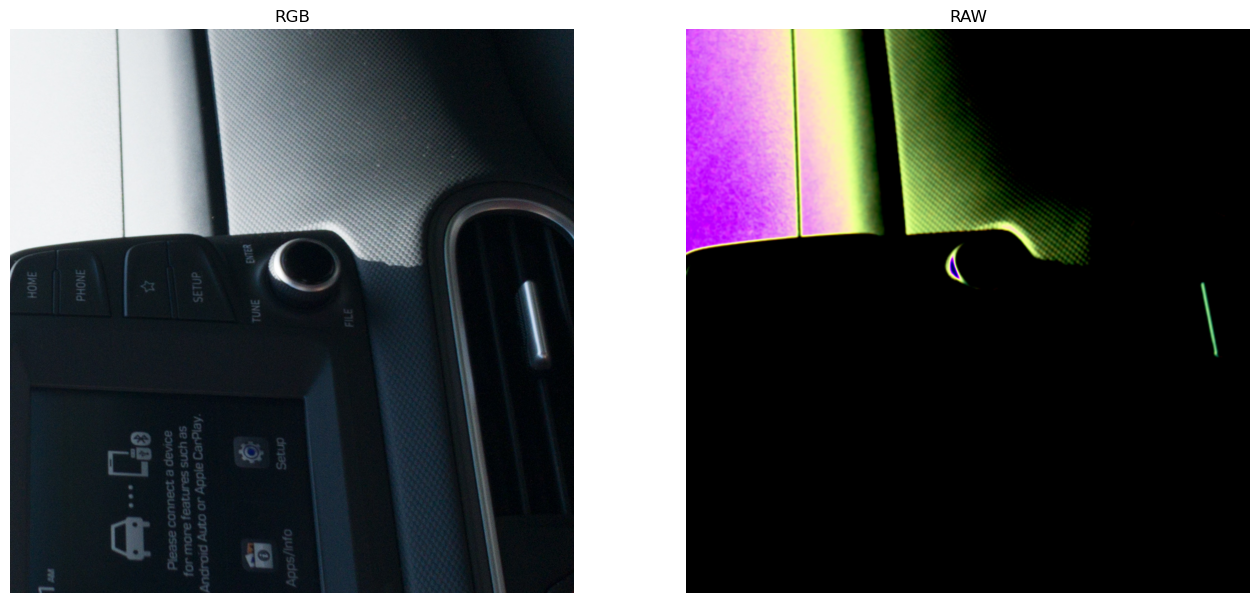

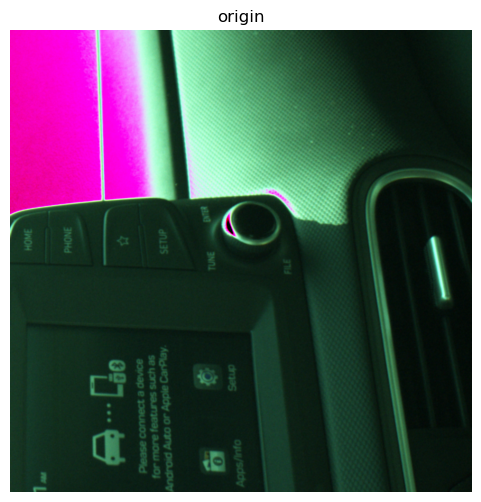

In [19]:
# InvLSP & ParamISP
showimg('train\\1043')